## Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [1]:
import json
import os
import shutil

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from PIL import Image
from tqdm import tqdm

import multiprocessing
from functools import partial

DATASET_ROOT = "/mnt/elice/dataset"  # Îç∞Ïù¥ÌÑ∞ ÏÖãÏùò Î£®Ìä∏ ÎîîÎ†âÌÜ†Î¶¨
LABELS_DIR = "labels"
IMAGE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"
# DATASET_ROOT/train/labels: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò ÎùºÎ≤® ÌååÏùºÏù¥ ÏûàÎäî ÎîîÎ†âÌÜ†Î¶¨
# DATASET_ROOT/train/images: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏù¥ ÏûàÎäî ÎîîÎ†âÌÜ†Î¶¨
# DATASET_ROOT/test/labels: ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò ÎùºÎ≤® ÌååÏùºÏù¥ ÏûàÎäî ÎîîÎ†âÌÜ†Î¶¨
# DATASET_ROOT/test/images: ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏù¥ ÏûàÎäî ÎîîÎ†âÌÜ†Î¶¨

### ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [2]:
train_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR, image)
    label_path = os.path.join(DATASET_ROOT, TRAIN_DIR, LABELS_DIR, image_id + ".txt")
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                x = float(line.split()[1])
                y = float(line.split()[2])
                w = float(line.split()[3])
                h = float(line.split()[4])
                labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})

    train_data.append({"id": image_id, "image_path": image_path, "label_path": label_path, "labels": labels})

df_train = pd.DataFrame(train_data)
# df_train.head()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14867/14867 [00:08<00:00, 1832.65it/s]


### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [3]:
test_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, image)

    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Îäî ÎùºÎ≤® ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§.
    test_data.append({"id": image_id, "image_path": image_path, "label_path": "", "labels": []})

df_test = pd.DataFrame(test_data)
# df_test.head()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6369/6369 [00:00<00:00, 157948.55it/s]


## ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ÌïòÍ∏∞

### ÏÉòÌîå Ïù¥ÎØ∏ÏßÄ

### ÏÉòÌîå Ïù¥ÎØ∏ÏßÄÏùò ÎùºÎ≤®

ÎùºÎ≤®ÏùÄ YOLO ÌòïÏãùÏúºÎ°ú Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏäµÎãàÎã§.

YOLO ÌòïÏãù
`<object-class> <x> <y> <width> <height>`
- object-class: Î¨ºÏ≤¥Ïùò ÌÅ¥ÎûòÏä§
- x, y: Î∞îÏö¥Îî© Î∞ïÏä§Ïùò Ï§ëÏã¨Ïùò ÏÉÅÎåÄ Ï¢åÌëú(0~1 ÏÇ¨Ïù¥ Í∞í)
- width, height: Î∞îÏö¥Îî© Î∞ïÏä§Ïùò ÎÑàÎπÑÏôÄ ÎÜíÏù¥(0~1 ÏÇ¨Ïù¥ Í∞í)

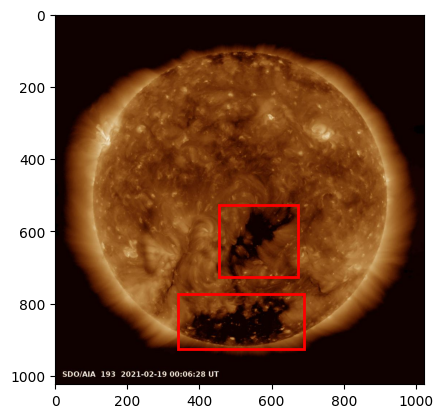

In [4]:
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ df_trainÏóêÏÑú Ï≤´ Î≤àÏß∏ ÏÉòÌîåÏùÑ Í∞ÄÏ†∏Ïò¥
sample = df_train.iloc[1]

# ÌîåÎ°Ø(fig)Í≥º Ï∂ï(ax)ÏùÑ ÏÉùÏÑ±
fig, ax = plt.subplots()

# ÏÉòÌîåÏùò Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÏóêÏÑú Ïù¥ÎØ∏ÏßÄÎ•º Ïó¥Í∏∞
img = Image.open(sample["image_path"])

# Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
ax.imshow(img)

# ÏÉòÌîåÏùò ÎùºÎ≤® Ï†ïÎ≥¥Ïóê ÎåÄÌï¥ Î∞îÏö¥Îî© Î∞ïÏä§Î•º Í∑∏Î¶º
for label in sample["labels"]:
    # Î∞îÏö¥Îî© Î∞ïÏä§ Ï§ëÏã¨ Ï¢åÌëú(c_x, c_y)Î•º Ïù¥ÎØ∏ÏßÄÏùò Ï†àÎåÄ Ï¢åÌëúÎ°ú Î≥ÄÌôò
    c_x = label["x"] * img.width
    c_y = label["y"] * img.height
    
    # Î∞îÏö¥Îî© Î∞ïÏä§Ïùò ÎÑàÎπÑ(w)ÏôÄ ÎÜíÏù¥(h)Î•º Ïù¥ÎØ∏ÏßÄÏùò Ï†àÎåÄ ÌÅ¨Í∏∞Î°ú Î≥ÄÌôò
    w = label["w"] * img.width
    h = label["h"] * img.height

    # Î∞îÏö¥Îî© Î∞ïÏä§Ïùò Ï¢åÏÉÅÎã®(left_top_x, left_top_y) Ï¢åÌëú Í≥ÑÏÇ∞
    left_top_x = c_x - w / 2
    left_top_y = c_y - h / 2

    # ÏÇ¨Í∞ÅÌòï Í∞ùÏ≤¥Î•º ÏÉùÏÑ±ÌïòÏó¨ Î∞îÏö¥Îî© Î∞ïÏä§Î•º Í∑∏Î¶¨Í∏∞
    # Ï¢åÏÉÅÎã® Ï¢åÌëú (left_top_x, left_top_y)ÏóêÏÑú ÏãúÏûëÌïòÏó¨ ÎÑàÎπÑ w, ÎÜíÏù¥ hÏùò ÏÇ¨Í∞ÅÌòïÏùÑ Í∑∏Î¶º
    rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    
    # ÏÉùÏÑ±Îêú ÏÇ¨Í∞ÅÌòï(rect)ÏùÑ Ïù¥ÎØ∏ÏßÄ(ax)Ïóê Ï∂îÍ∞Ä
    ax.add_patch(rect)

# ÌîåÎ°ØÏùÑ ÌëúÏãú
# fig.show()


## Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

### Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨

In [5]:
# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ df_trainÏóêÏÑú 80%Ïùò Îç∞Ïù¥ÌÑ∞Î•º Î¨¥ÏûëÏúÑÎ°ú ÏÉòÌîåÎßÅÌïòÏó¨ ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ÏÖã(df_train_set)ÏùÑ ÏÉùÏÑ±
df_train_set = df_train.sample(frac=0.8, random_state=42)

# df_train_setÏóê Ìè¨Ìï®ÎêòÏßÄ ÏïäÏùÄ ÎÇòÎ®∏ÏßÄ 20% Îç∞Ïù¥ÌÑ∞Î•º Í≤ÄÏ¶ùÏö© Îç∞Ïù¥ÌÑ∞ÏÖã(df_valid_set)ÏúºÎ°ú ÏÑ§Ï†ï
df_valid_set = df_train.drop(df_train_set.index)

# ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ 'train_set.csv' ÌååÏùºÎ°ú Ï†ÄÏû•
df_train_set.to_csv("train_set.csv", index=False)

# Í≤ÄÏ¶ùÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ 'valid_set.csv' ÌååÏùºÎ°ú Ï†ÄÏû•
df_valid_set.to_csv("valid_set.csv", index=False)

# 'train' ÎîîÎ†âÌÑ∞Î¶¨Ïùò Ï†àÎåÄ Í≤ΩÎ°úÎ•º ÏñªÏñ¥ÏÑú new_train_path Î≥ÄÏàòÏóê Ï†ÄÏû•
new_train_path = os.path.abspath("train")

# 'valid' ÎîîÎ†âÌÑ∞Î¶¨Ïùò Ï†àÎåÄ Í≤ΩÎ°úÎ•º ÏñªÏñ¥ÏÑú new_valid_path Î≥ÄÏàòÏóê Ï†ÄÏû•
new_valid_path = os.path.abspath("valid")

# 'new_train_path' ÎîîÎ†âÌÑ∞Î¶¨Î•º ÏÉùÏÑ± (Ïù¥ÎØ∏ Ï°¥Ïû¨Ìï¥ÎèÑ ÏóêÎü¨ ÏóÜÏù¥ Í≥ÑÏÜç ÏßÑÌñâ)
os.makedirs(new_train_path, exist_ok=True)

# 'new_train_path' ÎîîÎ†âÌÑ∞Î¶¨ ÏïàÏóê Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ï†ÄÏû•Ìï† 'IMAGE_DIR' ÎîîÎ†âÌÑ∞Î¶¨Î•º ÏÉùÏÑ±
os.makedirs(os.path.join(new_train_path, IMAGE_DIR), exist_ok=True)

# 'new_train_path' ÎîîÎ†âÌÑ∞Î¶¨ ÏïàÏóê ÎùºÎ≤® ÌååÏùºÏùÑ Ï†ÄÏû•Ìï† 'LABELS_DIR' ÎîîÎ†âÌÑ∞Î¶¨Î•º ÏÉùÏÑ±
os.makedirs(os.path.join(new_train_path, LABELS_DIR), exist_ok=True)

# 'new_valid_path' ÎîîÎ†âÌÑ∞Î¶¨Î•º ÏÉùÏÑ± (Ïù¥ÎØ∏ Ï°¥Ïû¨Ìï¥ÎèÑ ÏóêÎü¨ ÏóÜÏù¥ Í≥ÑÏÜç ÏßÑÌñâ)
os.makedirs(new_valid_path, exist_ok=True)

# 'new_valid_path' ÎîîÎ†âÌÑ∞Î¶¨ ÏïàÏóê Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ï†ÄÏû•Ìï† 'IMAGE_DIR' ÎîîÎ†âÌÑ∞Î¶¨Î•º ÏÉùÏÑ±
os.makedirs(os.path.join(new_valid_path, IMAGE_DIR), exist_ok=True)

# 'new_valid_path' ÎîîÎ†âÌÑ∞Î¶¨ ÏïàÏóê ÎùºÎ≤® ÌååÏùºÏùÑ Ï†ÄÏû•Ìï† 'LABELS_DIR' ÎîîÎ†âÌÑ∞Î¶¨Î•º ÏÉùÏÑ±
os.makedirs(os.path.join(new_valid_path, LABELS_DIR), exist_ok=True)


### Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Î≥µÏÇ¨

Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î•º Î≥ÄÍ≤ΩÌïòÍ≥† Í∞ÅÍ∞Å Ìè¥ÎçîÏóê Î≥µÏÇ¨Ìï©ÎãàÎã§.

YOLO Î™®Îç∏ÏùÄ ÏÉÅÎåÄ Ï¢åÌëúÎ•º ÏÇ¨Ïö©ÌïòÎØÄÎ°ú Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Í∞Ä Î≥ÄÍ≤ΩÎêòÏñ¥ÎèÑ ÏÉÅÎåÄ Ï¢åÌëúÎäî Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.

ÏÇ¨Ïö©ÌïòÎ†§Îäî Î™®Îç∏Ïù¥ Ï†àÎåÄ Ï¢åÌëúÎ•º ÏÇ¨Ïö©ÌïúÎã§Î©¥ Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î•º Î≥ÄÍ≤ΩÌï† Îïå ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Ï¢åÌëúÎ•º Î≥ÄÍ≤ΩÌï¥Ïïº Ìï©ÎãàÎã§.

In [6]:
IMAGE_SIZE = 640

def process_row(row, is_train):
    image = Image.open(row["image_path"])
    if is_train:
        image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_path}/{IMAGE_DIR}/{row['id']}.jpg")
        shutil.copy(row["label_path"], f"{new_train_path}/{LABELS_DIR}/{row['id']}.txt")
    else:
        image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_path}/{IMAGE_DIR}/{row['id']}.jpg")
        shutil.copy(row["label_path"], f"{new_valid_path}/{LABELS_DIR}/{row['id']}.txt")

def parallel_process(df_list, is_train):
    func = partial(process_row, is_train=is_train)
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(func, df_list), total=len(df_list)))

if __name__ == "__main__":
    # DataFrameÏùÑ ÎîïÏÖîÎÑàÎ¶¨Ïùò Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
    train_list = df_train_set.to_dict('records')
    valid_list = df_valid_set.to_dict('records')

    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
    parallel_process(train_list, is_train=True)
    
    # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
    parallel_process(valid_list, is_train=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2973/2973 [00:09<00:00, 320.10it/s]


## Î™®Îç∏ ÌïôÏäµ

### Î™®Îç∏ Ï§ÄÎπÑ

Ïô∏Î∂Ä Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞ ÏïÑÎûòÏ≤òÎüº Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò¨ Ïàò ÏûàÏäµÎãàÎã§.

- Îã§Ïö¥Î°úÎìú ÌïòÎäî ÏΩîÎìúÎ•º Î™ÖÏãú
- ÌïÑÏöîÌïú Ï¢ÖÏÜçÏÑ±ÏùÑ ÏÑ§ÏπòÌïòÎäî ÏΩîÎìúÎ•º Î™ÖÏãú

In [7]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 üöÄ Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)
Setup complete ‚úÖ (16 CPUs, 192.0 GB RAM, 20.2/50.0 GB disk)


### Î™®Îç∏ ÌïôÏäµ

In [8]:
import os

# ÌòÑÏû¨ ÎîîÎ†âÌÑ∞Î¶¨Ïùò Ï†àÎåÄ Í≤ΩÎ°úÎ•º ÏñªÏñ¥ÏôÄÏÑú dataset ÎîïÏÖîÎÑàÎ¶¨Ïóê Ï†ÄÏû•
dataset = {
    "path": os.path.abspath("."),  # ÌòÑÏû¨ ÏûëÏóÖ ÎîîÎ†âÌÑ∞Î¶¨Ïùò Ï†àÎåÄ Í≤ΩÎ°ú
    "train": "train",  # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÄÏû•Îêú ÎîîÎ†âÌÑ∞Î¶¨ Ïù¥Î¶Ñ
    "val": "valid",  # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÄÏû•Îêú ÎîîÎ†âÌÑ∞Î¶¨ Ïù¥Î¶Ñ
    "nc": 3,  # ÌÉêÏßÄÌï† ÌÅ¥ÎûòÏä§Ïùò Ïàò (Ïòà: coronal_hole, sunspot, prominence)
    "names": ["coronal_hole", "sunspot", "prominence"],  # ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ Î¶¨Ïä§Ìä∏
}

# YAML ÌååÏùºÏùÑ Ï†ÄÏû•Ìï† Í≤ΩÎ°úÎ•º ÏßÄÏ†ï
YAML_PATH = os.path.abspath("sun.yaml")

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîîÎ†âÌÑ∞Î¶¨ Í≤ΩÎ°úÎ•º ÏßÄÏ†ïÌïòÍ≥†, Ìï¥Îãπ ÎîîÎ†âÌÑ∞Î¶¨Í∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
RESULT_PATH = os.path.abspath("result30")
os.makedirs(RESULT_PATH, exist_ok=True)

# dataset ÎîïÏÖîÎÑàÎ¶¨Î•º YAML ÌòïÏãùÏúºÎ°ú ÌååÏùºÎ°ú Ï†ÄÏû•
import yaml
with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [9]:
!yolo train data={YAML_PATH} pretrained=False model=yolov8l.yaml epochs=300 lr0=0.005 batch=-1 imgsz=640 augment=True workers=12 project={RESULT_PATH} name=sun cache=True device=0 amp=True dropout=0.2 patience=15


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

## Î™®Îç∏ ÌèâÍ∞Ä

### Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°

In [10]:
!yolo predict model={os.path.join(RESULT_PATH, 'sun/weights/best.pt')} source={os.path.join(new_valid_path, IMAGE_DIR)} conf=0.5 save=True save_txt=True save_conf=True exist_ok=True project={os.path.join(RESULT_PATH, 'valid5')}

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

### ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî

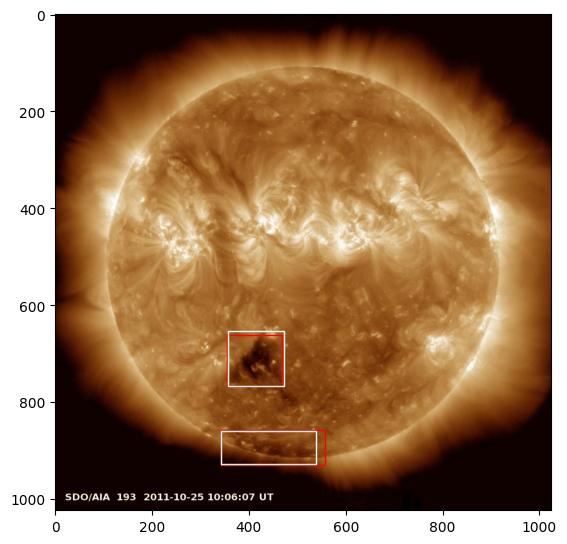

In [11]:
sample = df_valid_set.iloc[10]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
predict = os.path.join(RESULT_PATH, "valid5", "predict", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# Ï†ïÎãµ ÏãúÍ∞ÅÌôî
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

## Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±

### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°

In [12]:
!yolo predict model={os.path.join(RESULT_PATH, 'sun/weights/best.pt')} source={os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR)} conf=0.5 save=True save_txt=True save_conf=True exist_ok=True project={os.path.join(RESULT_PATH, 'test5')}

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

### Î∞îÏö¥Îìú Î∞ïÏä§ ÏùΩÏñ¥Ïò§Í∏∞

In [13]:
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    label_path = os.path.join(RESULT_PATH, "test5", "predict", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test.at[i, "labels"] = labels
df_test

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6369/6369 [00:00<00:00, 6923.78it/s]


id  \
0     8abb1e02042142928d5280eb2137d538   
1     e2019257735b4230b8669e8372b9b339   
2     2e31937421354646854d599dccc2c80e   
3     29da3a3a93ec4c71b5415cfaac520831   
4     4d02b3570c414445b34516800e5eef75   
...                                ...   
6364  7a78ae524a5046889713af57538adbee   
6365  c45fea81e7db468496d57044fa4f3e5a   
6366  2715986383dc466ca338bd7167ce1fd6   
6367  e94fad68d94348168d8cf3482e49f7b3   
6368  b5c5c578e7d64772968914b53637227e   

                                             image_path label_path  \
0     /mnt/elice/dataset/test/images/8abb1e020421429...              
1     /mnt/elice/dataset/test/images/e2019257735b423...              
2     /mnt/elice/dataset/test/images/2e3193742135464...              
3     /mnt/elice/dataset/test/images/29da3a3a93ec4c7...              
4     /mnt/elice/dataset/test/images/4d02b3570c41444...              
...                                                 ...        ...   
6364  /mnt/elice/dataset/test/images/7a78ae524a50468...              
6365  /mnt/elice/dataset/test/images/c45fea81e7db468...              
6366  /mnt/elice/dataset/test/images/2715986383dc466...              
6367  /mnt/elice/dataset/test/images/e94fad68d943481...              
6368  /mnt/elice/dataset/test/images/b5c5c578e7d6477...              

                                                 labels  
0     [{'class_id': 1, 'conf': 0.889283, 'x': 0.7804...  
1                                                    []  
2     [{'class_id': 2, 'conf': 0.752552, 'x': 0.2070...  
3     [{'class_id': 1, 'conf': 0.883767, 'x': 0.3481...  
4     [{'class_id': 0, 'conf': 0.894245, 'x': 0.5137...  
...                                                 ...  
6364  [{'class_id': 2, 'conf': 0.835766, 'x': 0.2249...  
6365  [{'class_id': 2, 'conf': 0.859859, 'x': 0.8301...  
6366  [{'class_id': 1, 'conf': 0.874717, 'x': 0.8347...  
6367  [{'class_id': 1, 'conf': 0.880566, 'x': 0.4184...  
6368  [{'class_id': 1, 'conf': 0.881433, 'x': 0.2638...  

[6369 rows x 4 columns]

### ÏÉùÏÑ±ÎêòÎäî CSV ÌååÏùºÏùò ÌòïÏãù

CSV ÌååÏùºÏùÄ Í∞Å Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú Ï†ïÎ≥¥Î•º Ìè¨Ìï®ÌïòÎ©∞, Îã§ÏùåÍ≥º Í∞ôÏùÄ Ïó¥(column)Î°ú Íµ¨ÏÑ±Îê©ÎãàÎã§: 

| id        | labels                             | 
|-----------|------------------------------------| 
| image_id  | [{"class_id": ..., "x": ..., "y": ..., "w": ..., "h": ...}, ...] | 

Í∞Å Ìñâ(row)ÏùÄ Îã§ÏùåÍ≥º Í∞ôÏùÄ ÎÇ¥Ïö©ÏùÑ Ìè¨Ìï®Ìï©ÎãàÎã§: 
- id: Ïù¥ÎØ∏ÏßÄÏùò Í≥†Ïú† ÏãùÎ≥ÑÏûê (image_id) 
- labels: Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú ÎùºÎ≤® Ï†ïÎ≥¥Î•º Ìè¨Ìï®ÌïòÎäî Î¶¨Ïä§Ìä∏ 
  - Í∞Å ÎùºÎ≤®ÏùÄ Îã§ÏùåÍ≥º Í∞ôÏùÄ Ï†ïÎ≥¥Î•º Ìè¨Ìï®Ìï©ÎãàÎã§: 
    - class_id: Í∞ùÏ≤¥Ïùò ÌÅ¥ÎûòÏä§ ID 
    - x: Í∞ùÏ≤¥Ïùò x Ï¢åÌëú (YOLO ÌòïÏãù) 
    - y: Í∞ùÏ≤¥Ïùò y Ï¢åÌëú (YOLO ÌòïÏãù) 
    - w: Í∞ùÏ≤¥Ïùò ÎÑàÎπÑ (YOLO ÌòïÏãù) 
    - h: Í∞ùÏ≤¥Ïùò ÎÜíÏù¥ (YOLO ÌòïÏãù) 

ÏòàÏãú: 
| id         | labels                                                       | 
|------------|--------------------------------------------------------------| 
| image_001  | [{"class_id": 1, "x": 0.5, "y": 0.5, "w": 0.2, "h": 0.3}] | 
| image_002  | [{"class_id": 2, "x": 0.3, "y": 0.4, "w": 0.1, "h": 0.2}, {"class_id": 1, "x": 0.7, "y": 0.8, "w": 0.15, "h": 0.25}] | 

Ï£ºÏùò: YOLO ÌòïÏãùÏùò x, y, w, hÎäî Í∞ÅÍ∞Å Ïù¥ÎØ∏ÏßÄÏùò ÎÑàÎπÑÏôÄ ÎÜíÏù¥Ïóê ÎåÄÌïú ÎπÑÏú®Î°ú ÌëúÌòÑÎêòÎ©∞, 
      xÏôÄ yÎäî Í∞ùÏ≤¥Ïùò Ï§ëÏã¨ Ï¢åÌëúÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÌïòÍ≥†, wÏôÄ hÎäî Í∞ùÏ≤¥Ïùò ÌÅ¨Í∏∞Î•º ÎÇòÌÉÄÎÉÖÎãàÎã§.

### Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±

In [14]:
submission = []  # ÏµúÏ¢Ö Ï†úÏ∂úÏö© Îç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò Í∞Å ÌñâÏùÑ ÏàúÌöåÌïòÎ©¥ÏÑú Ï≤òÎ¶¨
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    image_id = row["id"]  # ÌòÑÏû¨ ÌñâÏùò Ïù¥ÎØ∏ÏßÄ IDÎ•º Í∞ÄÏ†∏Ïò¥
    labels = []  # ÌòÑÏû¨ Ïù¥ÎØ∏ÏßÄÏùò ÏòàÏ∏° Î†àÏù¥Î∏îÎì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî
    
    # Í∞Å Î†àÏù¥Î∏î(ÏòàÏ∏°Îêú Í∞ùÏ≤¥)Ïóê ÎåÄÌï¥ Ï≤òÎ¶¨
    for label in row["labels"]:
        class_id = label["class_id"]  # ÏòàÏ∏°Îêú Í∞ùÏ≤¥Ïùò ÌÅ¥ÎûòÏä§ ID
        x = label["x"]  # ÏòàÏ∏°Îêú Í∞ùÏ≤¥Ïùò x Ï¢åÌëú
        y = label["y"]  # ÏòàÏ∏°Îêú Í∞ùÏ≤¥Ïùò y Ï¢åÌëú
        w = label["w"]  # ÏòàÏ∏°Îêú Í∞ùÏ≤¥Ïùò ÎÑàÎπÑ(width)
        h = label["h"]  # ÏòàÏ∏°Îêú Í∞ùÏ≤¥Ïùò ÎÜíÏù¥(height)

        # Í∞ùÏ≤¥ Ï†ïÎ≥¥Î•º ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉúÎ°ú Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
        labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})
    
    # Í∞Å Ïù¥ÎØ∏ÏßÄ IDÏôÄ Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄÏùò Î†àÏù¥Î∏î Î¶¨Ïä§Ìä∏Î•º ÎîïÏÖîÎÑàÎ¶¨Î°ú Î¨∂Ïñ¥ submission Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
    submission.append({"id": image_id, "labels": labels})

# ÏµúÏ¢Ö Ï†úÏ∂úÏö© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±
df_submission = pd.DataFrame(submission)

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ CSV ÌååÏùºÎ°ú Ï†ÄÏû• (Ïù∏Îç±Ïä§Îäî Ï†úÏô∏)
df_submission.to_csv("submission.csv", index=False)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6369/6369 [00:00<00:00, 17629.15it/s]


### Ï†úÏ∂ú ÌååÏùº ÌôïÏù∏

Ï†úÏ∂úÌïú ÌååÏùºÏù¥ Ïò¨Î∞îÎ•∏ ÌòïÏãùÏù∏ÏßÄ ÌôïÏù∏Ìï©ÎãàÎã§.

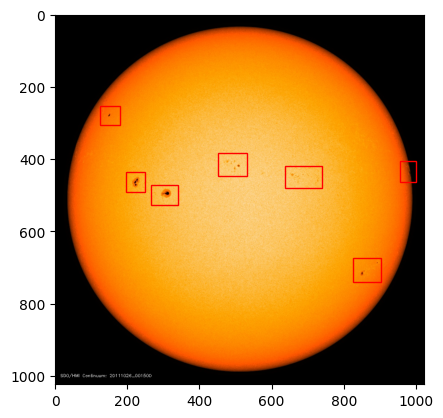

In [15]:
# 'submission.csv' ÌååÏùºÏùÑ ÏùΩÏñ¥ÏôÄ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò
df_submission = pd.read_csv("submission.csv")

# 11Î≤àÏß∏ ÌñâÏùò ÏòàÏ∏° Í≤∞Í≥ºÎ•º ÏÑ†ÌÉù
sample = df_submission.iloc[13]

# 'labels' Ïó¥Ïùò Í∞íÏùÑ Î¨∏ÏûêÏó¥Î°ú ÏùΩÏñ¥Îì§Ïù¥Í∏∞ ÎïåÎ¨∏Ïóê Ïù¥Î•º ÌèâÍ∞ÄÌïòÏó¨ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
sample_labels = eval(sample["labels"])

# ÏòàÏ∏°Îêú Î†àÏù¥Î∏îÏù¥ ÏóÜÎäî Í≤ΩÏö∞
if len(sample_labels) == 0:
    print("ÏòàÏ∏°Í≤∞Í≥º: Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄÏóêÏÑ† Î∞úÍ≤¨Îêú Ïù¥Î≤§Ìä∏Í∞Ä ÏóÜÏäµÎãàÎã§.")
else:
    # Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú Ï§ÄÎπÑ
    fig, ax = plt.subplots()
    
    # Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ïó¥Í≥† Ïù¥Î•º ÏãúÍ∞ÅÌôî
    img = Image.open(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, sample["id"] + ".jpg"))
    ax.imshow(img)

    # ÏòàÏ∏°Îêú Í∞ùÏ≤¥Ïùò ÏúÑÏπòÏôÄ ÌÅ¨Í∏∞Î•º ÏÇ¨Í∞ÅÌòïÏúºÎ°ú ÌëúÏãú
    for label in sample_labels:
        class_id = label["class_id"]  # ÌÅ¥ÎûòÏä§ IDÎ•º Í∞ÄÏ†∏Ïò¥
        cx = label["x"] * img.width   # Ï§ëÏã¨ x Ï¢åÌëúÎ•º ÏõêÎûò Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Î≥ÄÌôò
        cy = label["y"] * img.height  # Ï§ëÏã¨ y Ï¢åÌëúÎ•º ÏõêÎûò Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Î≥ÄÌôò
        w = label["w"] * img.width    # ÎÑàÎπÑÎ•º ÏõêÎûò Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Î≥ÄÌôò
        h = label["h"] * img.height   # ÎÜíÏù¥Î•º ÏõêÎûò Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å Î≥ÄÌôò

        # Ï¢åÏÉÅÎã® Ï¢åÌëú Í≥ÑÏÇ∞ (YOLO ÌòïÏãùÏùÄ Ï§ëÏã¨ Ï¢åÌëúÎ•º ÏÇ¨Ïö©ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Î≥ÄÌôòÏù¥ ÌïÑÏöî)
        left_top_x = cx - (w / 2)
        left_top_y = cy - h / 2

        # ÏÇ¨Í∞ÅÌòï Ìå®Ïπò ÏÉùÏÑ± Î∞è ÏãúÍ∞ÅÌôîÏóê Ï∂îÍ∞Ä
        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)  # Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê ÏÇ¨Í∞ÅÌòïÏùÑ Í∑∏Î†§ Í∞ùÏ≤¥Ïùò ÏúÑÏπòÎ•º ÌëúÏãú


## Ï†úÏ∂ú

Ïò§Î•∏Ï™Ω ÏúÑÏùò 'Ï†úÏ∂ú' Î≤ÑÌäºÏùÑ ÌÅ¥Î¶≠ÌïòÏó¨ Ï†úÏ∂úÌï©ÎãàÎã§.